In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import BinaryCrossentropy
import pandas as pd

# 데이터 경로 설정
root = './datasets/PandasBears/original/'

# ImageDataGenerator 설정
idg = ImageDataGenerator()
generator = idg.flow_from_directory(root, target_size=(224, 224), batch_size=32, class_mode='binary')
print(generator.class_indices)

# 데이터프레임 생성
target_name = {v: k for k, v in generator.class_indices.items()}
target_names = [target_name[target] for target in generator.classes]
df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
df.file_paths = df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))
print(df)

# 데이터 분할
train_images, test_images, train_targets, test_targets = train_test_split(
    df.file_paths, df.targets, stratify=df.targets, test_size=0.2, random_state=124
)
train_images, validation_images, train_targets, validation_targets = train_test_split(
    train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124
)

train_df = pd.DataFrame({'file_paths': train_images, 'target_names': [target_name[target] for target in train_targets], 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': validation_images, 'target_names': [target_name[target] for target in validation_targets], 'targets': validation_targets})
test_df = pd.DataFrame({'file_paths': test_images, 'target_names': [target_name[target] for target in test_targets], 'targets': test_targets})

print(train_df.shape, validation_df.shape, test_df.shape)

# 이미지 전처리 함수
def preprocessing_scaling_for_train(image, mode='tf'):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5), 
        A.VerticalFlip(p=0.5), 
        A.OneOf([
            A.ColorJitter(p=1), 
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)
        ], p=1)
    ], p=0.5)
    image = aug(image=image)['image']
    if mode == 'tf':
        image = image / 127.5 - 1.
    elif mode == 'torch':
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = (image - mean) / std
    return image

def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf':
        image = image / 127.5 - 1.
    elif mode == 'torch':
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = (image - mean) / std
    return image

# 데이터 생성기 설정
IMAGE_SIZE = 150
BATCH_SIZE = 8

train_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling_for_train)
validation_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)
test_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)

train_flow = train_generator.flow_from_dataframe(
    dataframe=train_df, x_col='file_paths', y_col='target_names',
    target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode='binary', shuffle=True, batch_size=BATCH_SIZE
)
validation_flow = validation_generator.flow_from_dataframe(
    dataframe=validation_df, x_col='file_paths', y_col='target_names',
    target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode='binary', batch_size=BATCH_SIZE
)
test_flow = test_generator.flow_from_dataframe(
    dataframe=test_df, x_col='file_paths', y_col='target_names',
    target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode='binary', batch_size=BATCH_SIZE
)

print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

# 모델 생성 함수
def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
        
    x = model.output
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

# 콜백 설정
mcp_cb = ModelCheckpoint(
    filepath="./callback_files/PandasBears/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.keras",
    monitor='val_loss', save_best_only=False, save_weights_only=False, mode='min'
)
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='min')
ely_cb = EarlyStopping(monitor='val_loss', patience=4, mode='min')

# 학습률 스케줄러 설정
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)

# 모델 컴파일 및 학습
model = create_model(model_name='mobilenet', verbose=True)
model.compile(optimizer=Adam(1e-4), loss=BinaryCrossentropy(), metrics=['acc'])

N_EPOCHS = 20
history = model.fit(train_flow, 
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_flow, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb, lr_scheduler])



Found 600 images belonging to 2 classes.
{'Bears': 0, 'Pandas': 1}
                                         file_paths target_names  targets
0      ./datasets/PandasBears/original/Bears/1.jpeg        Bears        0
1     ./datasets/PandasBears/original/Bears/10.jpeg        Bears        0
2    ./datasets/PandasBears/original/Bears/100.jpeg        Bears        0
3    ./datasets/PandasBears/original/Bears/101.jpeg        Bears        0
4    ./datasets/PandasBears/original/Bears/102.jpeg        Bears        0
..                                              ...          ...      ...
595  ./datasets/PandasBears/original/Pandas/95.jpeg       Pandas        1
596  ./datasets/PandasBears/original/Pandas/96.jpeg       Pandas        1
597  ./datasets/PandasBears/original/Pandas/97.jpeg       Pandas        1
598  ./datasets/PandasBears/original/Pandas/98.jpeg       Pandas        1
599  ./datasets/PandasBears/original/Pandas/99.jpeg       Pandas        1

[600 rows x 3 columns]
(384, 3) (96, 3) (120

C:\Users\user\AppData\Local\Temp\ipykernel_18008\538331442.py:109: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 75, 75, 32)        │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 75, 75, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 75, 75, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 75, 75, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 75, 75, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 75, 75, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 75, 75, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 75, 75, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 75, 75, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 75, 75, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 75, 75, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 77, 77, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 38, 38, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,322,085 (8.86 MB)

 Trainable params: 2,287,973 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/20


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - acc: 0.6051 - loss: 0.6921 - val_acc: 1.0000 - val_loss: 0.0432 - learning_rate: 1.0000e-04
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - acc: 0.7784 - loss: 0.4412 - val_acc: 1.0000 - val_loss: 0.0165 - learning_rate: 1.0000e-04
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - acc: 0.8537 - loss: 0.3468 - val_acc: 1.0000 - val_loss: 0.0084 - learning_rate: 1.0000e-04
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - acc: 0.8407 - loss: 0.3425 - val_acc: 1.0000 - val_loss: 0.0031 - learning_rate: 1.0000e-04
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - acc: 0.8430 - loss: 0.3438 - val_acc: 1.0000 - val_loss: 0.0024 - learning_rate: 1.0000e-04
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - acc: 0.8898 - loss: 0.2406 - val_acc: 1.0000 - val_loss: 6.9174e-04 - learning_rate: 1.0000e-04
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - acc: 0.8445 - loss: 0.3411 - val_acc: 1.0000 - val_loss: 6.6766e-04 - learni

ValueError: File not found: filepath=./callback_files/PandasBears/weights.015-0.0002-0.9688.weights.keras. Please ensure the file is an accessible `.keras` zip file.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


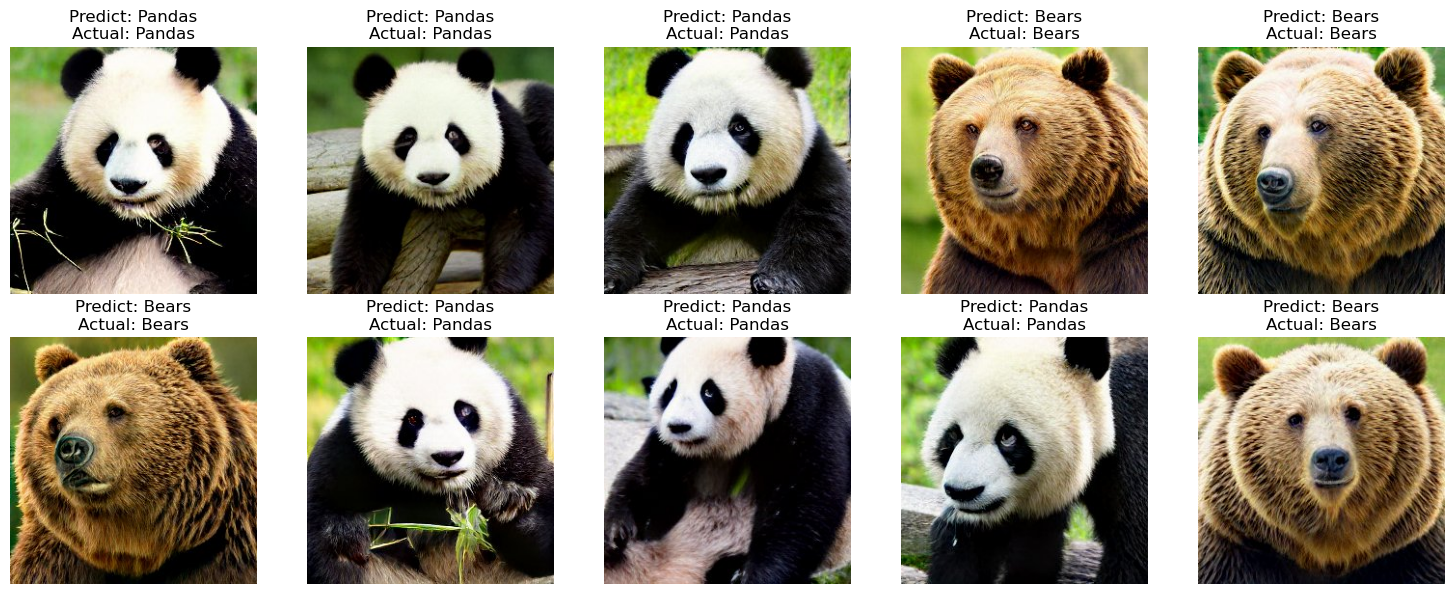

In [6]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A

# 모델 로드
model = load_model('./callback_files/PandasBears/mobilenet/weights.015-0.0002-0.9688.weights.keras')

# 이미지 예측
IMAGE_DIR = './datasets/PandasBears/original/'
class_names = ['Bears', 'Pandas']

def load_random_images(image_dir, class_names, num_images=10):
    selected_classes = random.choices(class_names, k=num_images)
    images = []
    labels = []
    
    for class_name in selected_classes:
        class_dir = os.path.join(image_dir, class_name)
        all_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith('.jpeg')]
        selected_image = random.choice(all_images)
        images.append(selected_image)
        labels.append(class_name)
    
    return images, labels

def preprocess_image(image_path, image_size, mode='tf'):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (image_size, image_size))
    preprocessed_image = preprocessing_scaling(resized_image, mode=mode)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    return preprocessed_image

random_images, random_labels = load_random_images(IMAGE_DIR, class_names, num_images=10)

plt.figure(figsize=(15, 6))  # 적절한 크기로 설정합니다.

for idx, image_path in enumerate(random_images):
    preprocessed_image = preprocess_image(image_path, IMAGE_SIZE, mode='tf')
    predictions = model.predict(preprocessed_image)
    predicted_class = int(predictions[0] > 0.5)  # Binary classification
    predicted_class_name = class_names[predicted_class]
    
    # 이미지 시각화
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, idx + 1)  # 2x5 그리드로 이미지 시각화
    plt.imshow(image)
    plt.title(f"Predict: {predicted_class_name}\nActual: {random_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()